In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
from os import walk
from skimage.io import imread
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### загрузка датасета GTZAN

In [2]:
def loadDataset(data="ms"):
    dataset = []
    path = "./Dataset/"
    if data == "ms":
        path += "Mel Spectrograms/"
    elif data == "mfcc":
        path += "MFCCs"
    else:
        raise Exception("Unexpected mode in load dataset call")

    for root, dirs, files in walk(path):
        if files:
            genreLabel = files[0].split('_')[0]
        for file in files:
            if data == "ms":
                curpath = path + root.split('/')[-1] + '/' + file
            else:
                curpath = path + '/' + root.split('\\')[-1] + '/' + file
            im = imread(curpath)
            if data == "mfcc":
                im = im.T
            dataset.append({"filename": file, "content": im, "class": genreLabel})
    
    df = pd.DataFrame(dataset)
    return df

In [3]:
df = loadDataset("mfcc")
df.head()

,filename,content,class
0,blues_00000.png,"[[19329, 60497, 54980, 58406, 54665, 56687, 53...",blues
1,blues_00001.png,"[[11076, 62781, 52951, 55002, 52333, 52803, 51...",blues
2,blues_00002.png,"[[27349, 61235, 50797, 54033, 52743, 55644, 52...",blues
3,blues_00003.png,"[[16625, 60769, 50536, 52640, 50269, 51951, 50...",blues
4,blues_00004.png,"[[15236, 62624, 52834, 54570, 51738, 53905, 51...",blues


In [4]:
df.shape

(998, 3)

In [5]:
df.isna().any()

filename    False
content     False
class       False
dtype: bool

In [6]:
df.duplicated(subset=['filename']).any()

np.False_

In [7]:
df.sample(5)

,filename,content,class
646,metal_00048.png,"[[36320, 63663, 59042, 62988, 57530, 60895, 58...",metal
58,blues_00058.png,"[[25621, 61088, 53090, 57661, 53418, 54840, 52...",blues
815,reggae_00017.png,"[[12677, 61387, 53774, 55123, 54377, 55812, 53...",reggae
465,hiphop_00066.png,"[[20362, 59965, 56127, 57710, 53657, 54527, 56...",hiphop
344,disco_00044.png,"[[29845, 57637, 51008, 51781, 51256, 54286, 54...",disco


In [8]:
df1 = df.drop(columns="filename")
df1.head()

,content,class
0,"[[19329, 60497, 54980, 58406, 54665, 56687, 53...",blues
1,"[[11076, 62781, 52951, 55002, 52333, 52803, 51...",blues
2,"[[27349, 61235, 50797, 54033, 52743, 55644, 52...",blues
3,"[[16625, 60769, 50536, 52640, 50269, 51951, 50...",blues
4,"[[15236, 62624, 52834, 54570, 51738, 53905, 51...",blues


In [9]:
print(set(df1["content"].apply(lambda x: np.shape(x))))

{(3004, 16)}


In [10]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df1["class"] = le.fit_transform(df1["class"])

df1["class"].value_counts()

class
0    100
1    100
2    100
3    100
7    100
6    100
8    100
9    100
5     99
4     99
Name: count, dtype: int64

In [11]:
label_map = {k: int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}
print(label_map)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [12]:
import json
with open("label_map.json", "w") as f:
    json.dump(label_map, f)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1["content"], df1["class"], test_size=0.2, random_state=40)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

flat_train = np.concatenate(X_train.values)
scaler.fit(flat_train)

X_train_scaled = X_train.apply(lambda x: scaler.transform(x))
X_test_scaled = X_test.apply(lambda x: scaler.transform(x))

In [15]:
y_train.value_counts()

class
7    83
1    83
3    83
5    81
2    80
8    79
4    79
0    78
6    77
9    75
Name: count, dtype: int64

In [16]:
y_test.value_counts()

class
9    25
6    23
0    22
8    21
2    20
4    20
5    18
3    17
1    17
7    17
Name: count, dtype: int64

In [17]:
X_train_T = torch.Tensor(np.stack(X_train_scaled.values)).unsqueeze(1)
y_train_T = torch.LongTensor(y_train.values)
train_data = torch.utils.data.TensorDataset(X_train_T, y_train_T)
print(len(train_data))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)

X_test_T = torch.Tensor(np.stack(X_test_scaled.values)).unsqueeze(1)
y_test_T = torch.LongTensor(y_test.values)
test_data = torch.utils.data.TensorDataset(X_test_T, y_test_T)
print(len(test_data))
val_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

798
200


### Train

In [18]:
def train_model(model, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    accuracy_history = []
    best_local_accuracy = 0.0
    best_local_state = None
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / (i + 1)
        train_losses.append(avg_loss)
        acc = evaluate_model(model)
        accuracy_history.append(acc)
        if acc > best_local_accuracy:
            best_local_accuracy = acc
            best_local_state = model.state_dict()
        print(f"Epoch №{epoch + 1}, loss: {avg_loss:.4f}, accuracy: {acc:.2f}%, time spent: {time.time() - epoch_start_time:.2f}s")
    return train_losses, accuracy_history, best_local_accuracy, best_local_state

def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def get_confusion_matrix(model):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    cm = confusion_matrix(targets, preds)
    ax = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    ax.plot(xticks_rotation=45, cmap='plasma')
    plt.title("Confusion Matrix")
    plt.show()

optimizers = {
    "SGD": lambda model : optim.SGD(model.parameters(), lr=1e-4),
    "AdaDelta":  lambda model : optim.Adadelta(model.parameters(), lr=1.0,rho=0.9),
    "Adam":  lambda model : optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
}

best_model_state = None
best_model_accuracy = 0.0
best_model_optimizer = ""

def train_optimizer(optimizer_name, modelclass, n=20):
    global best_model_state, best_model_accuracy, best_model_optimizer
    optimizer = optimizers.get(optimizer_name)
    print(f"Training with {optimizer_name} optimizer")
    model = modelclass.to(device)
    criterion = nn.CrossEntropyLoss()
    train_losses, accuracy_history, final_acc, model_state = train_model(model, criterion, optimizer(model), num_epochs=n)
    if optimizer_name == "SGD":
        index = 2
    elif optimizer_name == "AdaDelta":
        index = 0
    elif optimizer_name == "Adam":
        index = 1
    all_loss_histories[index] = train_losses
    all_accuracy_histories[index] = accuracy_history
    all_optimizer_names[index] = optimizer_name
    if final_acc > best_model_accuracy:
        best_model_accuracy = final_acc
        best_model_state = model_state
        best_model_optimizer = optimizer_name
    accuracy = accuracy_history[-1]
    print(f"{optimizer_name} optimizer, final accuracy: {accuracy:.2f}%\n")

all_loss_histories = [None, None]
all_accuracy_histories = [None, None]
all_optimizer_names = [None, None]

def plot_losses_and_accuracy(model_name, optimizer_names, loss_histories, accuracy_histories):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for optimizer_name, loss_history in zip(optimizer_names, loss_histories):
        plt.plot(loss_history, label=optimizer_name)
    plt.xlabel("Номер эпохи")
    plt.ylabel("Функция потерь")
    plt.title(f'Функция потерь для {model_name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    for optimizer_name, accuracy_history in zip(optimizer_names, accuracy_histories):
        plt.plot(accuracy_history, label=optimizer_name)
    plt.xlabel("Номер эпохи")
    plt.ylabel("Точность (Accuracy)")
    plt.title(f'Точность (Accuracy) для {model_name}')
    plt.legend()

### LeNet

In [19]:
from model_definitions import LeNet

In [20]:
train_optimizer("AdaDelta", LeNet(), n=75)

Training with AdaDelta optimizer
Epoch №1, loss: 2.3032, accuracy: 9.00%, time spent: 0.34s
Epoch №2, loss: 2.2928, accuracy: 16.00%, time spent: 0.13s
Epoch №3, loss: 2.2404, accuracy: 18.00%, time spent: 0.13s
Epoch №4, loss: 2.1872, accuracy: 15.50%, time spent: 0.13s
Epoch №5, loss: 2.1530, accuracy: 24.00%, time spent: 0.13s
Epoch №6, loss: 2.0959, accuracy: 28.50%, time spent: 0.13s
Epoch №7, loss: 1.9750, accuracy: 29.50%, time spent: 0.13s
Epoch №8, loss: 1.8983, accuracy: 33.00%, time spent: 0.13s
Epoch №9, loss: 1.8616, accuracy: 32.00%, time spent: 0.13s
Epoch №10, loss: 1.7677, accuracy: 28.50%, time spent: 0.13s
Epoch №11, loss: 1.6739, accuracy: 33.00%, time spent: 0.13s
Epoch №12, loss: 1.5586, accuracy: 33.50%, time spent: 0.14s
Epoch №13, loss: 1.5366, accuracy: 36.50%, time spent: 0.13s
Epoch №14, loss: 1.3256, accuracy: 34.00%, time spent: 0.13s
Epoch №15, loss: 1.1600, accuracy: 39.50%, time spent: 0.13s
Epoch №16, loss: 0.9789, accuracy: 41.50%, time spent: 0.13s
E

In [21]:
train_optimizer("Adam", LeNet(), n=75)

Training with Adam optimizer
Epoch №1, loss: 2.2850, accuracy: 17.00%, time spent: 0.13s
Epoch №2, loss: 2.2276, accuracy: 18.50%, time spent: 0.13s
Epoch №3, loss: 2.2005, accuracy: 20.50%, time spent: 0.14s
Epoch №4, loss: 2.1618, accuracy: 21.50%, time spent: 0.13s
Epoch №5, loss: 2.1022, accuracy: 25.00%, time spent: 0.13s
Epoch №6, loss: 2.0224, accuracy: 28.00%, time spent: 0.13s
Epoch №7, loss: 1.9293, accuracy: 28.50%, time spent: 0.13s
Epoch №8, loss: 1.8488, accuracy: 28.50%, time spent: 0.13s
Epoch №9, loss: 1.7603, accuracy: 29.00%, time spent: 0.13s
Epoch №10, loss: 1.6900, accuracy: 32.00%, time spent: 0.13s
Epoch №11, loss: 1.6267, accuracy: 36.00%, time spent: 0.15s
Epoch №12, loss: 1.5688, accuracy: 37.50%, time spent: 0.13s
Epoch №13, loss: 1.5245, accuracy: 38.50%, time spent: 0.13s
Epoch №14, loss: 1.4744, accuracy: 40.50%, time spent: 0.13s
Epoch №15, loss: 1.4240, accuracy: 44.50%, time spent: 0.13s
Epoch №16, loss: 1.3723, accuracy: 44.50%, time spent: 0.13s
Epoc

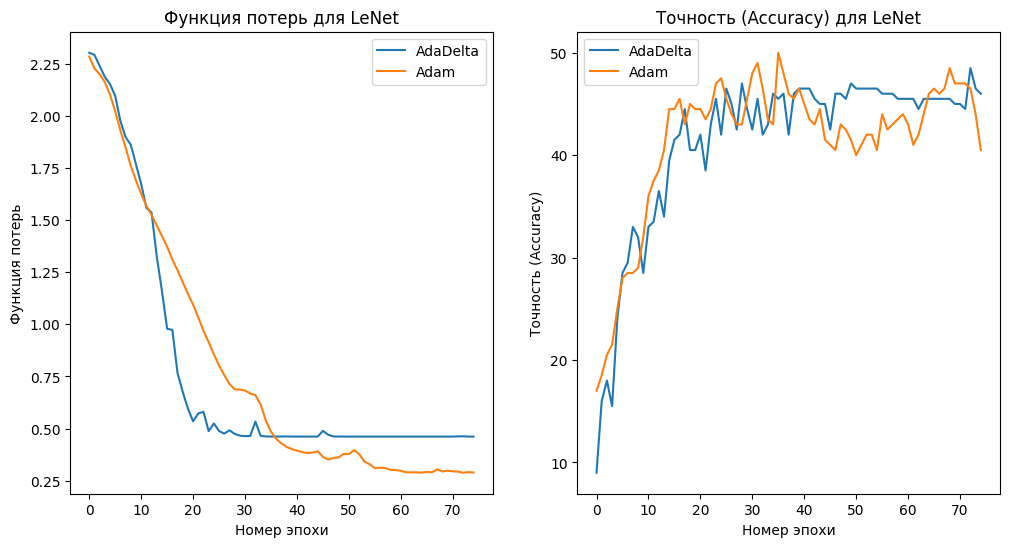

In [22]:
plot_losses_and_accuracy("LeNet", all_optimizer_names, all_loss_histories, all_accuracy_histories)
plt.show()

Best LeNet model saved: Optimizer=Adam, Accuracy=50.00%


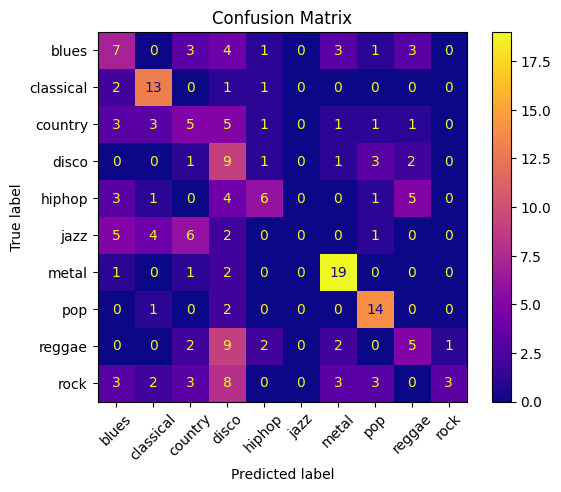

In [23]:
if best_model_state is not None:
    torch.save(best_model_state, f"LeNet_best.pt")
    print(f"Best LeNet model saved: Optimizer={best_model_optimizer}, Accuracy={best_model_accuracy:.2f}%")
    best_model = LeNet().to(device)
    best_model.load_state_dict(best_model_state)
    get_confusion_matrix(best_model)

### VGG16

In [24]:
optimizers = {
    "SGD": lambda model : optim.SGD(model.parameters(), lr=1e-3),
    "AdaDelta":  lambda model : optim.Adadelta(model.parameters(), lr=1.0,rho=0.9),
    "Adam":  lambda model : optim.Adam(model.parameters(), lr=4e-4)
}

best_model_state = None
best_model_accuracy = 0.0
best_model_optimizer = ""

all_loss_histories = [None, None, None]
all_accuracy_histories = [None, None, None]
all_optimizer_names = [None, None, None]

In [25]:
from model_definitions import VGG16

In [26]:
train_optimizer("SGD", VGG16())

Training with SGD optimizer
Epoch №1, loss: 2.1263, accuracy: 16.00%, time spent: 1.20s
Epoch №2, loss: 2.0657, accuracy: 37.50%, time spent: 1.10s
Epoch №3, loss: 1.6649, accuracy: 43.50%, time spent: 1.10s
Epoch №4, loss: 1.4038, accuracy: 47.50%, time spent: 1.11s
Epoch №5, loss: 1.1822, accuracy: 50.50%, time spent: 1.11s
Epoch №6, loss: 0.9886, accuracy: 53.50%, time spent: 1.11s
Epoch №7, loss: 0.8153, accuracy: 55.50%, time spent: 1.10s
Epoch №8, loss: 0.6596, accuracy: 55.50%, time spent: 1.10s
Epoch №9, loss: 0.5216, accuracy: 54.50%, time spent: 1.10s
Epoch №10, loss: 0.4039, accuracy: 54.50%, time spent: 1.06s
Epoch №11, loss: 0.3076, accuracy: 54.00%, time spent: 1.07s
Epoch №12, loss: 0.2330, accuracy: 54.00%, time spent: 1.07s
Epoch №13, loss: 0.1771, accuracy: 55.00%, time spent: 1.07s
Epoch №14, loss: 0.1361, accuracy: 54.50%, time spent: 1.14s
Epoch №15, loss: 0.1065, accuracy: 55.00%, time spent: 1.13s
Epoch №16, loss: 0.0851, accuracy: 54.50%, time spent: 1.07s
Epoch

In [27]:
train_optimizer("AdaDelta", VGG16())

Training with AdaDelta optimizer
Epoch №1, loss: 2.3992, accuracy: 23.50%, time spent: 1.60s
Epoch №2, loss: 2.4815, accuracy: 35.00%, time spent: 1.57s
Epoch №3, loss: 1.5546, accuracy: 33.50%, time spent: 1.57s
Epoch №4, loss: 1.3636, accuracy: 32.50%, time spent: 1.56s
Epoch №5, loss: 1.0811, accuracy: 43.00%, time spent: 1.57s
Epoch №6, loss: 0.8318, accuracy: 42.50%, time spent: 1.60s
Epoch №7, loss: 0.6730, accuracy: 50.00%, time spent: 1.65s
Epoch №8, loss: 0.1152, accuracy: 50.50%, time spent: 1.60s
Epoch №9, loss: 0.0502, accuracy: 51.50%, time spent: 1.55s
Epoch №10, loss: 0.0094, accuracy: 50.00%, time spent: 1.58s
Epoch №11, loss: 0.0040, accuracy: 53.50%, time spent: 1.58s
Epoch №12, loss: 0.0004, accuracy: 53.00%, time spent: 1.57s
Epoch №13, loss: 0.0002, accuracy: 53.50%, time spent: 1.57s
Epoch №14, loss: 0.0001, accuracy: 52.50%, time spent: 1.57s
Epoch №15, loss: 0.0001, accuracy: 53.00%, time spent: 1.57s
Epoch №16, loss: 0.0001, accuracy: 53.00%, time spent: 1.55s


In [28]:
train_optimizer("Adam", VGG16())

Training with Adam optimizer
Epoch №1, loss: 2.1954, accuracy: 14.00%, time spent: 1.44s
Epoch №2, loss: 2.4005, accuracy: 29.50%, time spent: 1.40s
Epoch №3, loss: 1.6871, accuracy: 35.50%, time spent: 1.41s
Epoch №4, loss: 1.3173, accuracy: 43.00%, time spent: 1.41s
Epoch №5, loss: 0.9888, accuracy: 50.00%, time spent: 1.40s
Epoch №6, loss: 0.6815, accuracy: 52.00%, time spent: 1.40s
Epoch №7, loss: 0.4106, accuracy: 53.00%, time spent: 1.41s
Epoch №8, loss: 0.2955, accuracy: 52.00%, time spent: 1.40s
Epoch №9, loss: 0.2250, accuracy: 50.00%, time spent: 1.40s
Epoch №10, loss: 0.2205, accuracy: 47.50%, time spent: 1.41s
Epoch №11, loss: 0.1259, accuracy: 55.00%, time spent: 1.42s
Epoch №12, loss: 0.0537, accuracy: 51.00%, time spent: 1.39s
Epoch №13, loss: 0.0466, accuracy: 50.50%, time spent: 1.41s
Epoch №14, loss: 0.0356, accuracy: 56.50%, time spent: 1.41s
Epoch №15, loss: 0.0311, accuracy: 55.50%, time spent: 1.42s
Epoch №16, loss: 0.0347, accuracy: 59.00%, time spent: 1.40s
Epoc

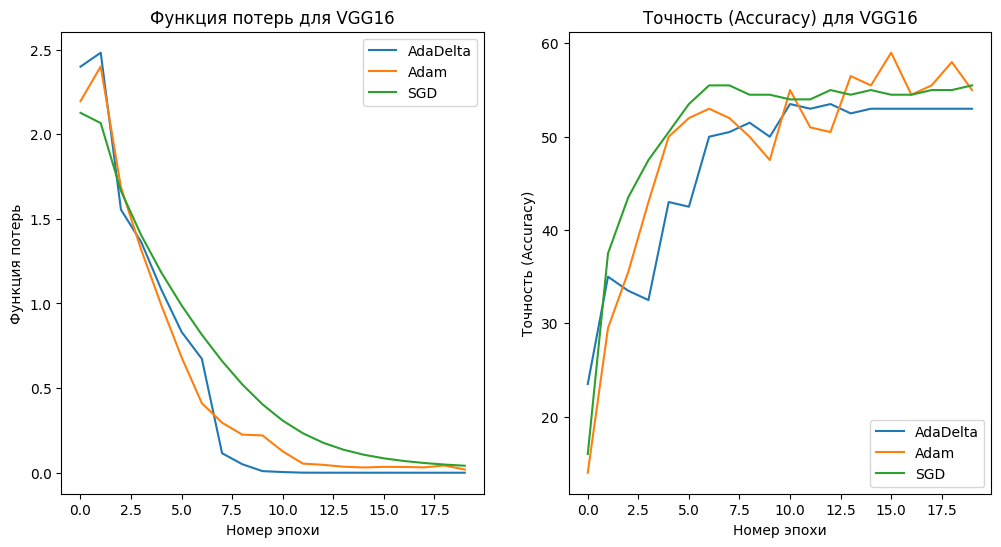

In [29]:
plot_losses_and_accuracy("VGG16", all_optimizer_names, all_loss_histories, all_accuracy_histories)
plt.show()

Best VGG model saved: Optimizer=Adam, Accuracy=59.00%


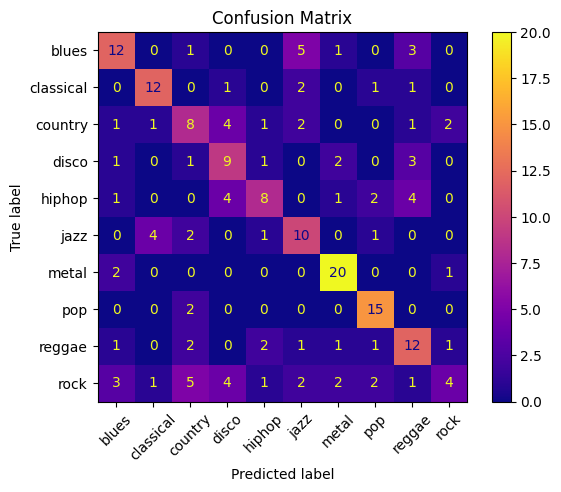

In [30]:
if best_model_state is not None:
    torch.save(best_model_state, f"VGG_best.pt")
    print(f"Best VGG model saved: Optimizer={best_model_optimizer}, Accuracy={best_model_accuracy:.2f}%")
    best_model = VGG16().to(device)
    best_model.load_state_dict(best_model_state)
    get_confusion_matrix(best_model)

### Resnet

In [59]:
optimizers = {
    "SGD": lambda model : optim.SGD(model.parameters(), lr=0.0025),
    "AdaDelta":  lambda model : optim.Adadelta(model.parameters(), lr=1.0,rho=0.9),
    "Adam":  lambda model : optim.Adam(model.parameters(), lr=2e-4)
}

best_model_state = None
best_model_accuracy = 0.0
best_model_optimizer = ""

all_loss_histories = [None, None, None]
all_accuracy_histories = [None, None, None]
all_optimizer_names = [None, None, None]

In [60]:
from model_definitions import Resnet

In [61]:
train_optimizer("SGD", Resnet(), n=50)

Training with SGD optimizer
Epoch №1, loss: 2.1790, accuracy: 19.50%, time spent: 3.93s
Epoch №2, loss: 2.1283, accuracy: 27.00%, time spent: 3.65s
Epoch №3, loss: 1.9309, accuracy: 33.00%, time spent: 3.77s
Epoch №4, loss: 1.8006, accuracy: 33.00%, time spent: 3.58s
Epoch №5, loss: 1.6934, accuracy: 35.50%, time spent: 3.66s
Epoch №6, loss: 1.6128, accuracy: 39.50%, time spent: 3.52s
Epoch №7, loss: 1.5426, accuracy: 42.50%, time spent: 3.50s
Epoch №8, loss: 1.4722, accuracy: 44.00%, time spent: 3.57s
Epoch №9, loss: 1.4092, accuracy: 42.50%, time spent: 3.54s
Epoch №10, loss: 1.3655, accuracy: 41.00%, time spent: 3.53s
Epoch №11, loss: 1.3223, accuracy: 42.50%, time spent: 3.60s
Epoch №12, loss: 1.2715, accuracy: 42.50%, time spent: 3.53s
Epoch №13, loss: 1.2314, accuracy: 42.00%, time spent: 3.53s
Epoch №14, loss: 1.1882, accuracy: 44.00%, time spent: 3.59s
Epoch №15, loss: 1.1523, accuracy: 47.00%, time spent: 3.73s
Epoch №16, loss: 1.1304, accuracy: 47.00%, time spent: 3.71s
Epoch

In [62]:
train_optimizer("AdaDelta", Resnet(), n=50)

Training with AdaDelta optimizer
Epoch №1, loss: 2.0378, accuracy: 22.00%, time spent: 3.94s
Epoch №2, loss: 2.7608, accuracy: 25.00%, time spent: 3.78s
Epoch №3, loss: 1.9123, accuracy: 26.50%, time spent: 3.81s
Epoch №4, loss: 1.7284, accuracy: 38.50%, time spent: 3.54s
Epoch №5, loss: 1.6839, accuracy: 35.00%, time spent: 3.56s
Epoch №6, loss: 1.6044, accuracy: 38.00%, time spent: 3.60s
Epoch №7, loss: 1.5052, accuracy: 36.50%, time spent: 3.54s
Epoch №8, loss: 1.4492, accuracy: 44.50%, time spent: 3.78s
Epoch №9, loss: 1.3614, accuracy: 40.50%, time spent: 3.55s
Epoch №10, loss: 1.3310, accuracy: 45.50%, time spent: 3.52s
Epoch №11, loss: 1.2539, accuracy: 44.00%, time spent: 3.58s
Epoch №12, loss: 1.1911, accuracy: 49.00%, time spent: 3.53s
Epoch №13, loss: 1.1268, accuracy: 45.50%, time spent: 3.52s
Epoch №14, loss: 1.0841, accuracy: 48.00%, time spent: 3.58s
Epoch №15, loss: 1.0098, accuracy: 48.50%, time spent: 3.52s
Epoch №16, loss: 0.9579, accuracy: 47.00%, time spent: 3.52s


In [63]:
train_optimizer("Adam", Resnet(), n=50)

Training with Adam optimizer
Epoch №1, loss: 2.1028, accuracy: 28.00%, time spent: 3.96s
Epoch №2, loss: 1.9021, accuracy: 24.50%, time spent: 3.68s
Epoch №3, loss: 1.6653, accuracy: 40.50%, time spent: 3.60s
Epoch №4, loss: 1.5171, accuracy: 44.50%, time spent: 3.57s
Epoch №5, loss: 1.3773, accuracy: 41.00%, time spent: 3.72s
Epoch №6, loss: 1.2732, accuracy: 46.00%, time spent: 3.67s
Epoch №7, loss: 1.1689, accuracy: 47.00%, time spent: 3.68s
Epoch №8, loss: 1.1301, accuracy: 52.50%, time spent: 3.71s
Epoch №9, loss: 0.9715, accuracy: 53.00%, time spent: 3.63s
Epoch №10, loss: 0.9499, accuracy: 52.00%, time spent: 3.63s
Epoch №11, loss: 0.8596, accuracy: 54.00%, time spent: 3.55s
Epoch №12, loss: 0.8219, accuracy: 53.50%, time spent: 3.52s
Epoch №13, loss: 0.8443, accuracy: 49.00%, time spent: 3.57s
Epoch №14, loss: 0.7800, accuracy: 52.50%, time spent: 3.54s
Epoch №15, loss: 0.6793, accuracy: 57.50%, time spent: 3.53s
Epoch №16, loss: 0.6064, accuracy: 58.50%, time spent: 3.55s
Epoc

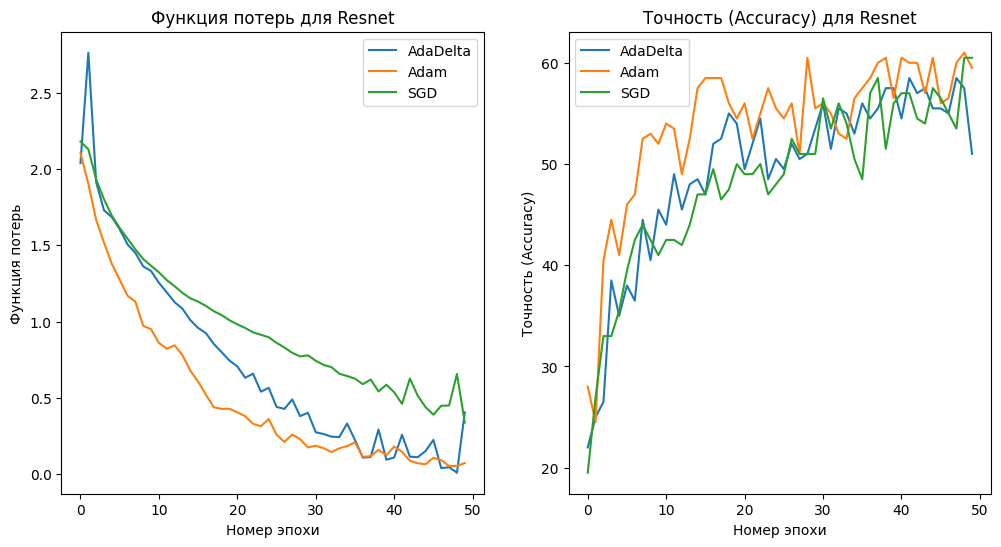

In [64]:
plot_losses_and_accuracy("Resnet", all_optimizer_names, all_loss_histories, all_accuracy_histories)
plt.show()

Best Resnet model saved: Optimizer=Adam, Accuracy=61.00%


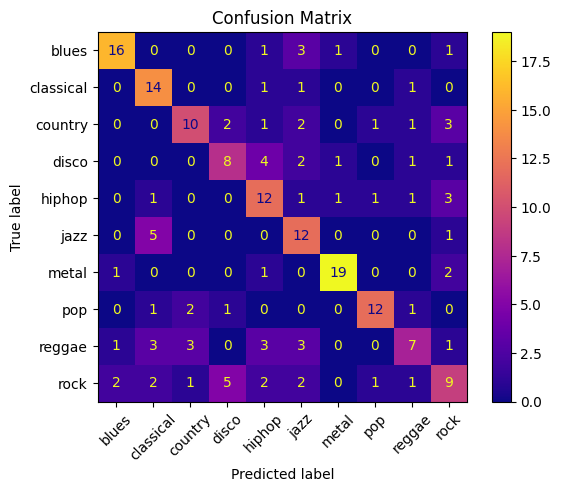

In [65]:
if best_model_state is not None:
    torch.save(best_model_state, f"Resnet_best.pt")
    print(f"Best Resnet model saved: Optimizer={best_model_optimizer}, Accuracy={best_model_accuracy:.2f}%")
    best_model = Resnet().to(device)
    best_model.load_state_dict(best_model_state)
    get_confusion_matrix(best_model)